#### Update content of the CPM Atlas - analysis plots for diurnal cycles of precipitation<br>
Author          : Team BETA<br>
Return Values   : png files<br>
Source data     : The data is preprocessed and provided by Petter Lind.

In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
# regridding
import xesmf as xe
# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# for clipping
import rioxarray

In [2]:
# path to datasets
path_data = "/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/diurnal"

In [3]:
# define availability of models by region
models_avai_cpm = {
    'NW': {
        'CNRM': 'nwe-3_cnrm-arome_cnrm-cm5',
        'KNMI': 'alp-3_hclim-knmi_ec-earth',
        'ETHZ': 'reu-3_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-3_mohc-um10.1_hadgem3-gc3.1', # reu-3 covers all the sub-regions
    },
    'SW': {
        'CMCC': 'swe-3_cclm_ec-earth',
        'IPSL': 'swe-3_ipsl-wrf_ipsl-cm6',
        'ETHZ': 'reu-3_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-3_mohc-um10.1_hadgem3-gc3.1'
    },
    'SE': {
        'ICTP': 'see-3_regcm4_hadgem2-es',
        'ETHZ': 'reu-3_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-3_mohc-um10.1_hadgem3-gc3.1'
    },
    'C': {
        'GERICS': 'ceu-3_gerics_mpi-esm-lr',
        'ETHZ': 'reu-3_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-3_mohc-um10.1_hadgem3-gc3.1'
    },
    'CE': {
        'DMI/SMHI': 'cee-3_hclim_ec-earth',
        'ICTP': 'cee-3_regcm4_hadgem2-es',
        'ETHZ': 'reu-3_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-3_mohc-um10.1_hadgem3-gc3.1'
    },
    'N': {
        'DMI/SMHI': 'neu-3_hclim_ec-earth',
        'GERICS': 'neu-3_gerics_mpi-esm-lr'
    },
    'AL': {
        'CNRM': 'alp-3_cnrm-arome_cnrm-cm5',
        'CMCC': 'alp-3_cclm_ec-earth',
        'IPSL': 'alp-3_ipsl-wrf_ipsl-cm5-mr',
        'KNMI': 'alp-3_hclim-knmi_ec-earth',
        'GERICS': 'alp-3_gerics_mpi-esm-lr',
        'ETHZ': 'alp-3_ethz-cclm_mpi',
        'DMI/SMHI': 'alp-3_hclim_ec-earth',
        'ICTP': 'alp-3_regcm4_hadgem2-es',
        'UKMO': 'reu-3_mohc-um10.1_hadgem3-gc3.1'
    }
}

models_avai_rcm = {
    'NW': {
        'CNRM': 'eur-11_cnrm_cnrm-cm5',
        'KNMI': 'wce-11_knmi-racmo_ec-earth',
        'ETHZ': 'eur-11_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-25_mohc-hadgem3-gc3.1',
    },
    'SW': {
        'CMCC': 'eur-11_cclm_ec-earth',
        'IPSL': 'med-18_regipslv1_ipsl-cm6',
        'ETHZ': 'eur-11_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-25_mohc-hadgem3-gc3.1'
    },
    'SE': {
        'ICTP': 'eur-11_regcm4_hadgem2-es',
        'ETHZ': 'eur-11_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-25_mohc-hadgem3-gc3.1'
    },
    'C': {
        'GERICS': 'eur-11_gerics_mpi-esm-lr',
        'ETHZ': 'eur-11_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-25_mohc-hadgem3-gc3.1'
    },
    'CE': {
        'DMI/SMHI': 'cee-12_hclim_ec-earth',
        'ICTP': 'eur-11_regcm4_hadgem2-es',
        'ETHZ': 'eur-11_ethz-cclm_ecmwf-erai',
        'UKMO': 'reu-25_mohc-hadgem3-gc3.1'
    },
    'N': {
        'DMI/SMHI': 'eur-11_hclim_ec-earth',
        'GERICS': 'eur-11_gerics_mpi-esm-lr'
    },
    'AL': {
        'CNRM': 'eur-11_cnrm_cnrm-cm5',
        'CMCC': 'eur-11_cclm_ec-earth',
        'IPSL': 'eur-15_ipsl-wrf_ipsl-cm5a-mr',
        'KNMI': 'wce-11_knmi-racmo_ec-earth',
        'GERICS': 'eur-11_gerics_mpi-esm-lr',
        'ETHZ': 'eur-11_ethz-cclm_mpi',
        'DMI/SMHI': 'alp-12_hclim_ec-earth',
        'ICTP': 'eur-11_regcm4_hadgem2-es',
        'UKMO': 'reu-25_mohc-hadgem3-gc3.1'
    }    
}

In [4]:
# define geometries for clipping by regions
regions = {
  "NW": [
    {
      'type': 'Polygon',
      'coordinates': [[[-8.0, 40.4], [11.0, 40.4], [15.2, 58.6], [-12.5, 58.6], [-8.0, 40.4]]]
    }
  ],
  "SW": [
    {
      'type': 'Polygon',
      'coordinates': [[[-10, 30], [7.4, 33], [5.7, 48.9], [-15, 45.4], [-10, 30]]]
    }
  ],
  "SE": [
    {
      'type': 'Polygon',
      'coordinates': [[[12.5, 34.3], [28.5, 34.3], [29.4, 40.9], [11.5, 40.9], [12.5, 34.3]]]
    }
  ],
  "C": [
    {
      'type': 'Polygon',
      'coordinates': [[[5.0, 44.5], [18.0, 45.5], [18.0, 56.0], [1.0, 53.0], [5.0, 44.5]]]
    }
  ],
  "CE": [
    {
      'type': 'Polygon',
      'coordinates': [[[17.8, 41.5], [31.3, 41.5], [32.8, 51.6], [16.4, 51.6], [17.8, 41.5]]]
    }
  ],
  "N": [
    {
      'type': 'Polygon',
      'coordinates': [[[1, 50.7], [26.7, 49.7], [44.1, 70.6], [-9.4, 72.6], [1, 50.7]]]
    }
  ],
  "AL": [
    {
      'type': 'Polygon',
      'coordinates': [[[1, 40], [17, 40], [17, 50], [1, 50], [1, 40]]]
    }
  ]
}

In [5]:
# define grid for regridding
lon = np.arange(-180, 180.1, 0.5)
lat = np.arange(-90, 90.1, 0.5)
target_grid = xr.Dataset(
    {"var":(("lat", "lon"),np.ones((len(lat), len(lon)), dtype=float))},
    coords={"lat": lat, "lon": lon}
    )
# for clipping package rioxarray to identify the coordinate system
target_grid.coords["lat"].attrs["axis"] = "Y"
target_grid.coords["lon"].attrs["axis"] = "X"

def region_clip(input_data_path, region, target_grid):
    #############################################################
    ###   regridding from model native grid to target grid    ###
    #############################################################    
    # load the input data
    input_data = xr.open_dataset(input_data_path)
    # mask input data
    # note that the mask is the same for all seasons
    input_data['mask'] = xr.where(~np.isnan(input_data["pr"].sel(hour= 0)), 1, 0)
    # create regridder
    regridder = xe.Regridder(input_data, target_grid, "bilinear")
    # use the regridder to regrid data
    input_data_regrid = regridder(input_data["pr"])
    #############################################################
    ###                   region clipping                     ###
    #############################################################
    # change filled values to 0, to avoid errors after clipping
    # input_data[f"{variable}"] = input_data[f"{variable}"].where(input_data[f"{variable}"]<1e+10, 0)
    # set-up the coordinate system known to rio
    input_data_regrid.rio.write_crs("EPSG:4326", inplace=True)
    # clip data
    clipped_data = input_data_regrid.rio.clip(regions[region], "EPSG:4326", all_touched=True)

    return clipped_data

In [6]:
# legend color
cmap = plt.cm.tab10

legend_color_book = {
    'CNRM': cmap(5),
    'CMCC': cmap(4),
    'IPSL': cmap(2),
    'KNMI': cmap(8),
    'GERICS': cmap(1),
    'ETHZ': cmap(0),
    'DMI/SMHI': cmap(6),
    'ICTP': cmap(7),
    'UKMO': cmap(3),
}

# function for making diagrams
def make_diagram(input_cpm_dict, input_rcm_dict, legend_color_book, outfile):
    # custom legend
    custom_lines = [Line2D([0], [0], color='k'),
                    Line2D([0], [0], color='k', ls= "--")]
    legend_labels = ['CPM', 'RCM']
    # Plot
    fig = plt.figure(dpi=120)
    for model in input_cpm_dict.keys():
        plt.plot(range(0, 24), input_cpm_dict[f'{model}'], color = legend_color_book[f'{model}'])
        custom_lines.append(Line2D([0], [0], color=legend_color_book[f'{model}']))
        legend_labels.append(f'{model}')
        # also include the rcm runs
        # temporal resolution is either 1hr or 3hr
        temporal_res = 24 // len(input_rcm_dict[f'{model}']['hour']) 
        plt.plot(range(0, 24, temporal_res), input_rcm_dict[f'{model}'], color = legend_color_book[f'{model}'], ls= "--")
    plt.xlim(1, 24)
    plt.xlabel('Hour', fontsize=12)
    plt.ylabel('mm/h', fontsize=12)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.title('Diurnal cycle | JJA', fontsize=12)
    plt.grid(True)
    lgd = plt.legend(custom_lines, legend_labels,
        bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    plt.tight_layout()
    #fig.savefig(outfile)
    fig.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.close()


In [7]:
# choose experiment
experiment = "rcp85"
projects = ["CPM", "RCM"]
#projects = ["CPM"]

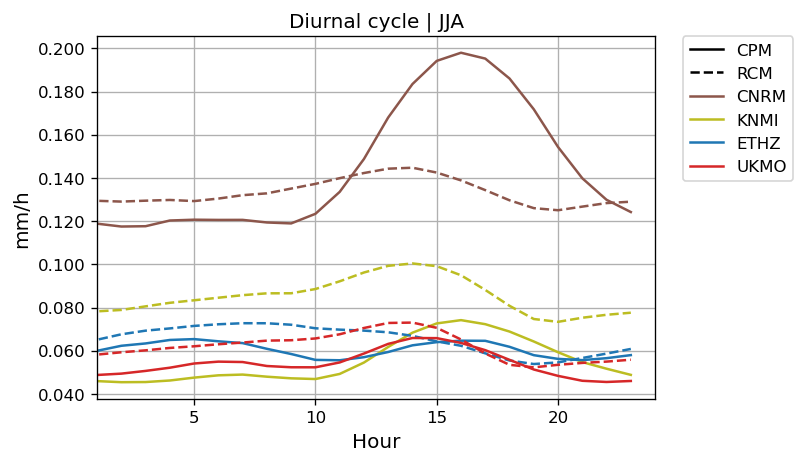

Create diagrams of precipitation diurnal cycles for NW.


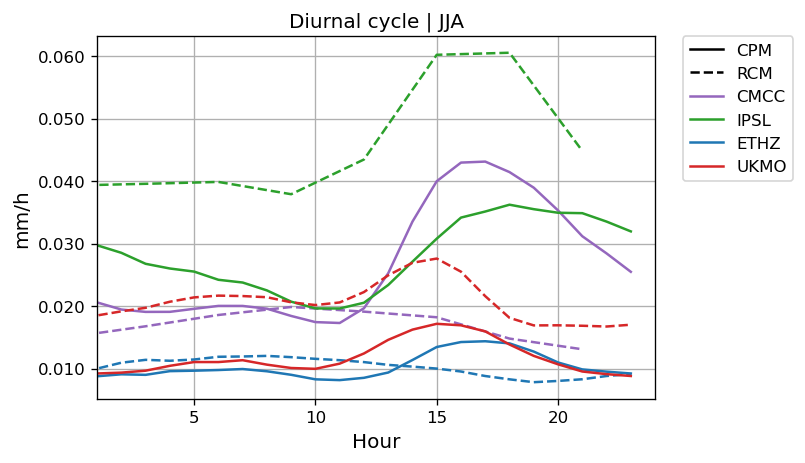

Create diagrams of precipitation diurnal cycles for SW.


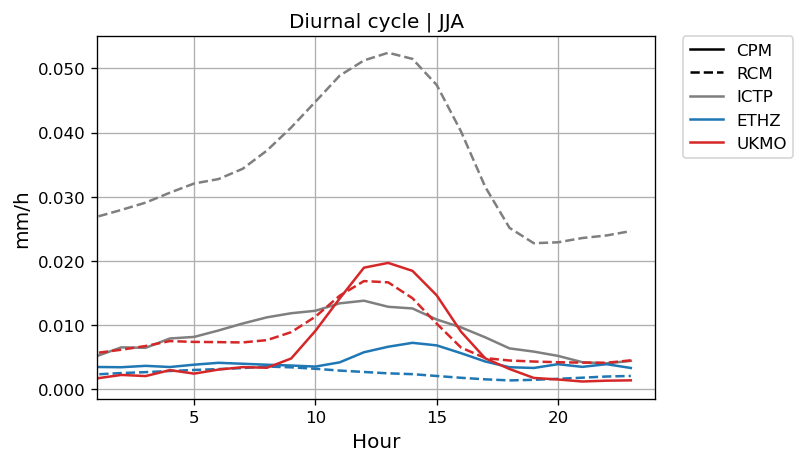

Create diagrams of precipitation diurnal cycles for SE.


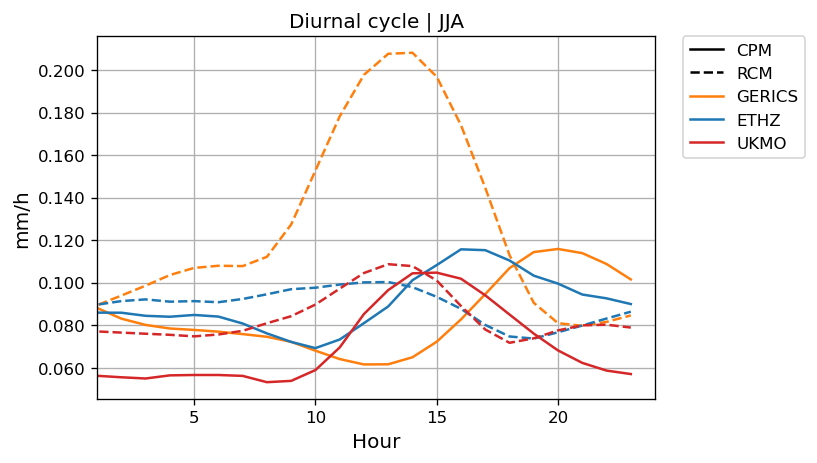

Create diagrams of precipitation diurnal cycles for C.


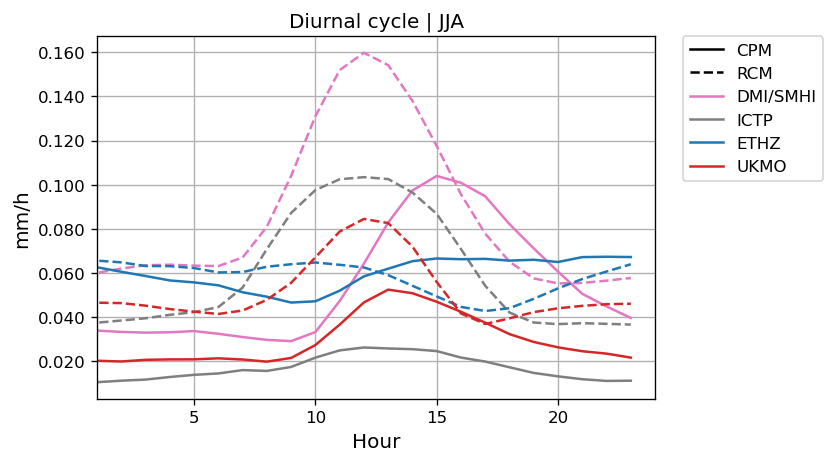

Create diagrams of precipitation diurnal cycles for CE.


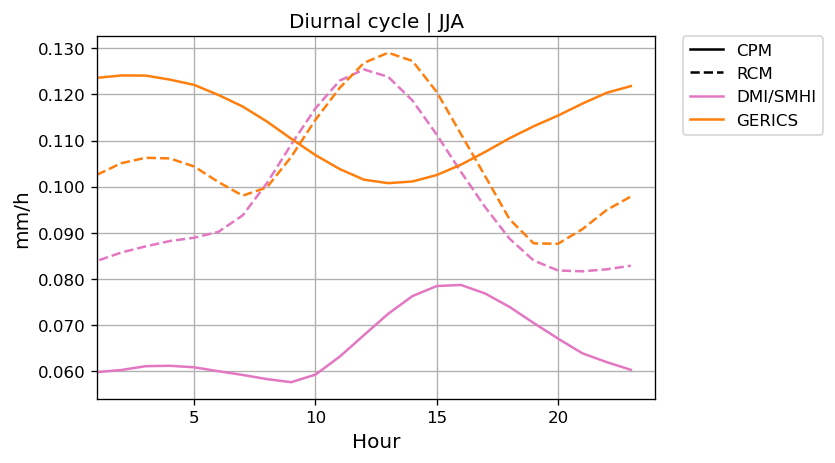

Create diagrams of precipitation diurnal cycles for N.


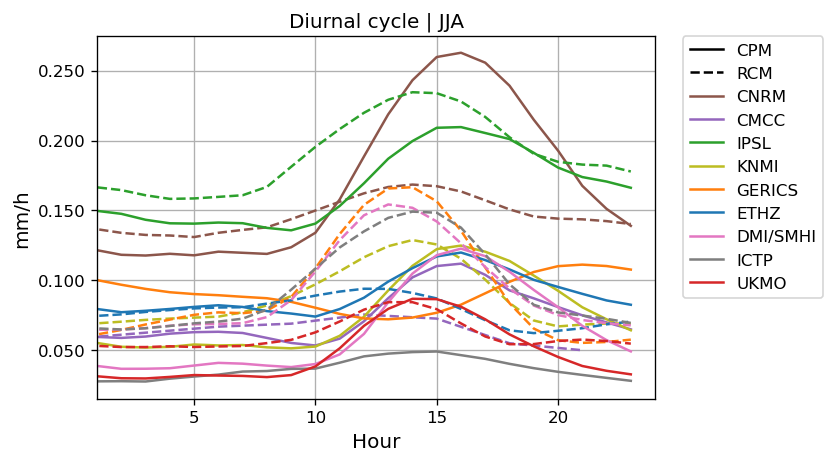

Create diagrams of precipitation diurnal cycles for AL.


In [8]:
for region_alias in regions.keys():
    # create empty dict to host the data
    precipitation_diurnal_cpm = {}
    precipitation_diurnal_rcm = {}
    for project in projects:
        directory = path_data + "/" + project
        # data processing for cpm runs
        if project == "CPM":
            for model in models_avai_cpm[f'{region_alias}'].keys():
                model_file = models_avai_cpm[f'{region_alias}'][f'{model}']
                # get the file that contains chosen model and experiment name
                ncfile = [data_file for data_file in Path(directory).iterdir()
                if(model_file in data_file.stem and experiment in data_file.stem)]
                # data regridding and clipping based on the region
                clipped_region = region_clip(ncfile[0], region_alias, target_grid)
                # take spatial mean of processed data and save it to the dict
                precipitation_diurnal_cpm[f'{model}'] = clipped_region.mean(axis=(1,2),skipna=True)
        # data processing for rcm runs
        elif project == "RCM":
            for model in models_avai_rcm[f'{region_alias}'].keys():
                model_file = models_avai_rcm[f'{region_alias}'][f'{model}']
                # get the file that contains chosen model and experiment name
                ncfile = [data_file for data_file in Path(directory).iterdir()
                if(model_file in data_file.stem and experiment in data_file.stem)]
                # data regridding and clipping based on the region
                clipped_region = region_clip(ncfile[0], region_alias, target_grid)
                # take spatial mean of processed data and save it to the dict
                precipitation_diurnal_rcm[f'{model}'] = clipped_region.mean(axis=(1,2),skipna=True)
        else:
            raise ValueError('Unknown project.')
    # make diagram
    outfile = (f"../static/cpm_analysis/analyse/{region_alias}_future_JJA.png")
    make_diagram(precipitation_diurnal_cpm, precipitation_diurnal_rcm,
        legend_color_book, outfile)
    # plot function
    print(f"Create diagrams of precipitation diurnal cycles for {region_alias}.")